Trying to remove negatives. Can't understand Parke's code, try my own.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.io.idl import readsav


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [5]:
path = '/media/david/5tb_storage1/muscles/'

In [6]:
testpath = path+ 'stis_hlsp/hlsp_muscles_hst_stis_gj674_g230l_v1_component-spec.ecsv' #testing on the gj674 nuv spectrum

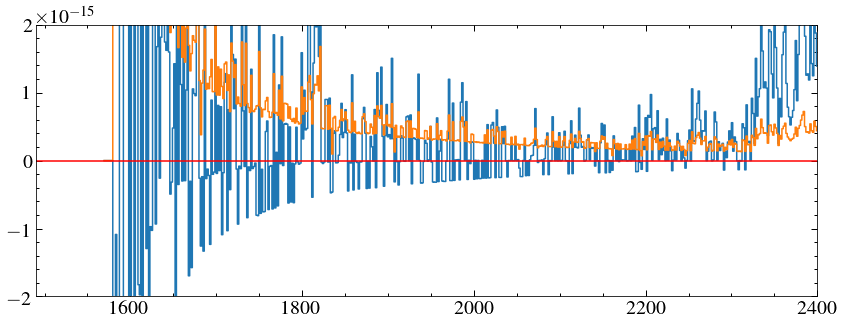

In [59]:
data = Table.read(testpath)
plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')
#plt.yscale('log')
plt.ylim(-0.2e-14, 0.2e-14)
plt.xlim(right=2400)
plt.axhline(0, c='r')

(array([  2.,   0.,   3.,   1.,   1.,   6.,  67., 315.,  40.,  15.,   7.,
          1.,   3.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-8.1239006e-15, -6.9996888e-15, -5.8754771e-15, -4.7512653e-15,
        -3.6270535e-15, -2.5028415e-15, -1.3786297e-15, -2.5441786e-16,
         8.6979399e-16,  1.9940058e-15,  3.1182175e-15,  4.2424293e-15,
         5.3666411e-15,  6.4908533e-15,  7.6150651e-15,  8.7392768e-15,
         9.8634886e-15,  1.0987700e-14,  1.2111912e-14,  1.3236124e-14,
         1.4360336e-14,  1.5484548e-14,  1.6608759e-14,  1.7732972e-14,
         1.8857183e-14,  1.9981395e-14,  2.1105606e-14,  2.2229819e-14,
         2.3354030e-14,  2.4478243e-14,  2.5602453e-14,  2.6726666e-14,
         2.7850877e-14,  2.8975090e-14,  3.0099302e-14,  3.1223515e-14,
         3

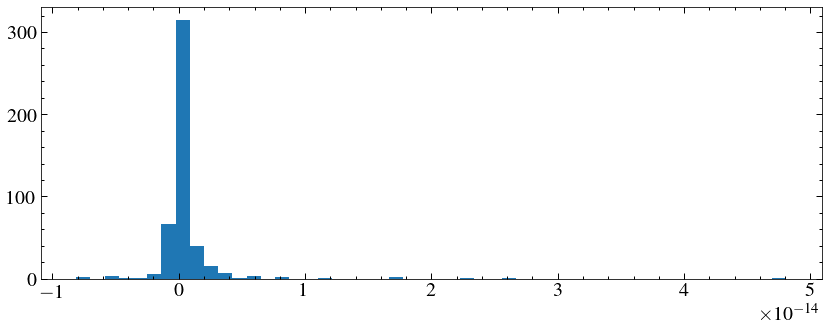

In [21]:
plt.hist(data['FLUX'][(data['WAVELENGTH'] < 2300) & (data['FLUX'] > -1e-14)], bins=50 )

192
1024 1024
88
721 721
3
700 700
0


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


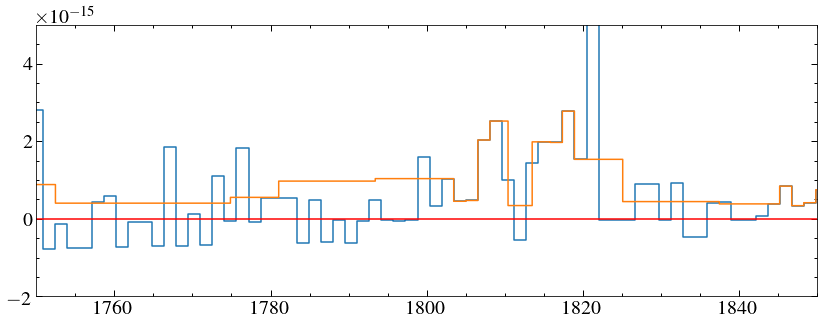

In [116]:
w, f = data['WAVELENGTH'],data['FLUX']
f1 = np.array(f)
w1= np.array(w)
nneg = len(f1[f1 < 0])
print(nneg)

#while nneg > 0:
 #   i = np.argmin(f)
  #  f1[i] = np.sum([f1[i-1], f[i], f[i+1]])
  #  nneg = len(f1[f1 < 0])
plt.step(w, f, where='mid')
trys = 0
inds_to_delete = []
while trys < 1000 and nneg > 0:
    negargs = np.where(f1 < 0)
    #print(len(negargs[0]))
    inds_to_delete = []
    for i in negargs[0]:
        
   #     plt.axvline(w[i])
        #print(i)
        #print(f1[i])
        f1[i] = np.trapz([f1[i-1], f1[i], f1[i+1]], [w1[i-1], w1[i], w1[i+1]])/(w[i+1]-(w[i-1]))
        #f1 = np.delete(f1, [i-1,i+1])
        #w1 = np.delete(w1, [i-1,i+1])
        #print(f1[i])
        inds_to_delete.append((i-1, i+1))
    
    print(len(w1), len(f1))
    nneg = len(f1[f1 < 0])
    print(nneg)
    trys +=1
    f1 = np.delete(f1,np.unique(inds_to_delete))
    w1 = np.delete(w1,np.unique(inds_to_delete))

    
#plt.step(w, f, where='mid')
plt.step(w1, f1, where='mid')
plt.ylim(-0.2e-14, 0.5e-14)
#plt.xlim(right=2400)
plt.xlim(1750, 1850)
plt.axhline(0, c='r')

Great! Need to get that to work with wavelength bins etc, but otherwise it looks good. Do before scaling?

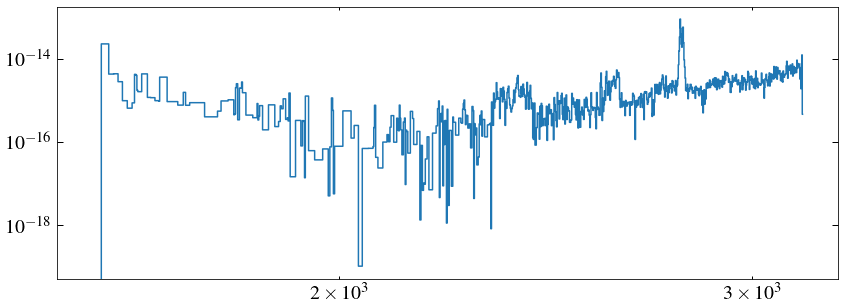

In [110]:
plt.step(w1, f1, where='mid')
plt.yscale('log')
plt.xscale('log')

How does that look compared with the fuv spectrum, scaling wise?

In [120]:
data2 = Table.read(path+ 'stis_hlsp/hlsp_muscles_hst_stis_gj674_g140l_v1_component-spec.ecsv')

(-1e-14, 3e-14)

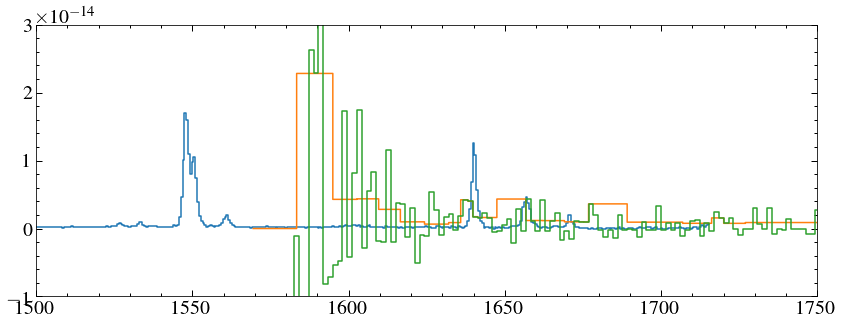

In [125]:
plt.step(data2['WAVELENGTH'], data2['FLUX'], where='mid')
plt.step(w1, f1, where='mid')
plt.step(data['WAVELENGTH'][data['DQ'] == 0], data['FLUX'][data['DQ'] == 0], where='mid')
plt.xlim(1500, 1750)
plt.ylim(-1e-14, 3e-14)

In [127]:
w2, f2 =data2['WAVELENGTH'], data2['FLUX']
mask1 = (w1 < w2[-1])
mask2 = (w2 > w1[0])
int1 = np.trapz(f1[mask1], w1[mask1])
int2 = np.trapz(f2[mask2], w2[mask2])
print(int1, int2)
print(int1/int2)

5.205396617364141e-13 6.77030364069092e-14
7.688571877454114
